<a href="https://colab.research.google.com/github/eunsun53/DeepLearning_stockprice_prediction/blob/main/LSTM_%EC%A3%BC%EC%8B%9D_%EA%B0%80%EA%B2%A9_%EC%98%88%EC%B8%A1_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식 가격 예측 프로그램 
> dataset : S&P 500 지수 데이터셋, 500개의 대기업(주로 미국)의 2000년 1월 ~ 2016년 8월 까지의 주식 종가 데이터 
> * sp500.csv

(1) LSTM 주식 가격 예측
> LSTM은 RNN의 일종으로, 이전의 입력값들을 함께 고려하여 데이터를 학습하기 때문에 time-seriese(시계열) 데이터를 학습하기에 좋다.
* LSTM은 RNN의 모델에서 cell-state의 개념을 도입해 어떤 정보를 기억하고 어떤 정보를 버릴지 학습함으로써 RNN의 vanishing gradient 문제를 해결해 길이가 긴 데이터에 대해서도 잘 학습한다.

(2) Deep Q-Learning, 강화학습 

# < LSTM 주식 가격 예측 >
 <데이터 load 및 준비>

In [ ]:
#드라이브-코랩 연동 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/dataset/sp500

/content/gdrive/MyDrive/dataset/sp500


In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential 

In [ ]:
import time 
#import warnings 
import numpy as np 
from numpy import newaxis 
import matplotlib.pyplot as plt 

In [ ]:
def load_data(filename, seq_len):
  f = open(filename, 'r').read()
  data = f.split('\n')

  sequence_length = seq_len + 1
  result = []
  for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

  

  # normalization: neural network의 빠른 학습을 위해 데이터 값을 -1 ~1로 정규화 
  # n_i = (p_i/p_0) -1 
  # 원 데이터 값으로 복원: p_i = p_0(n_i + 1)
  normalized_lst = []
  for d in result:
    tmp = [((float(p) / float(d[0]))-1) for p in d] # -1~1의 값을 가지도록 정규화(가장 첫 데이터인 2000년 1월 첫 거래일의 종가를 기준으로 증감 비율 연산) 
    normalized_lst.append(tmp)
  
  result = normalized_lst
  result = np.array(result)

  row = round(0.9 * result.shape[0])
  train = result[:int(row), :]
  np.random.shuffle(train)
  x_train = train[:, :-1]
  y_train = train[:, -1]
  x_test = result[int(row): , : -1]
  y_test = result[int(row): , -1]

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return x_train, y_train, x_test, y_test


In [ ]:
x_train, y_train, x_test, y_test = load_data('sp500.csv', 50)
print(x_train)

[[[0.        ]
  [0.00584872]
  [0.01122917]
  ...
  [0.05718853]
  [0.08056574]
  [0.080557  ]]

 [[0.        ]
  [0.01382794]
  [0.03087337]
  ...
  [0.0803416 ]
  [0.11057616]
  [0.10754797]]

 [[0.        ]
  [0.01700393]
  [0.01304251]
  ...
  [0.02459601]
  [0.02632   ]
  [0.00824519]]

 ...

 [[0.        ]
  [0.00281678]
  [0.00774437]
  ...
  [0.09775432]
  [0.09765547]
  [0.09248788]]

 [[0.        ]
  [0.00388869]
  [0.00772004]
  ...
  [0.09558353]
  [0.10316745]
  [0.08784924]]

 [[0.        ]
  [0.00565807]
  [0.00538383]
  ...
  [0.02573112]
  [0.02679462]
  [0.02057163]]]


In [ ]:
x_train.shape # 3709*(50*1)

(3709, 50, 1)

In [ ]:
y_train # 3709 * 1

array([0.07241995, 0.10544247, 0.0063994 , ..., 0.07157027, 0.10862454,
       0.03105683])

# <주식 종가예측 modeling - LSTM 모델 >


In [ ]:
model = Sequential()
model.add(LSTM(
    50, 
    return_sequences = True
))
model.add(Dropout(0.2)) # prevent over-fitting 
model.add(LSTM(
    100, 
    return_sequences = False
))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))

start_time = time.time()
model.compile(loss = 'mse', optimizer = 'rmsprop')
end_time = time.time()
print('compile time: {}'.format(end_time - start_time))


compile time: 0.007588863372802734


In [ ]:
# train model 
model.fit(
    x_train, 
    y_train,
    batch_size = 512, 
    epochs = 10, 
    validation_split = 0.05
)
model.summary()

Epoch 1/10
7/7 [==============================] - 9s 634ms/step - loss: 0.0020 - val_loss: 5.3962e-04
Epoch 2/10
7/7 [==============================] - 3s 500ms/step - loss: 8.3356e-04 - val_loss: 6.8917e-04
Epoch 3/10
7/7 [==============================] - 3s 491ms/step - loss: 6.7525e-04 - val_loss: 5.2277e-04
Epoch 4/10
7/7 [==============================] - 4s 504ms/step - loss: 4.9908e-04 - val_loss: 4.2473e-04
Epoch 5/10
7/7 [==============================] - 3s 490ms/step - loss: 7.0854e-04 - val_loss: 3.8783e-04
Epoch 6/10
7/7 [==============================] - 3s 497ms/step - loss: 4.1611e-04 - val_loss: 5.9653e-04
Epoch 7/10
7/7 [==============================] - 3s 497ms/step - loss: 6.3349e-04 - val_loss: 3.3036e-04
Epoch 8/10
7/7 [==============================] - 4s 539ms/step - loss: 3.9837e-04 - val_loss: 7.4266e-04
Epoch 9/10
7/7 [==============================] - 4s 503ms/step - loss: 5.0411e-04 - val_loss: 3.4262e-04
Epoch 10/10
7/7 [==============================] -

In [ ]:
!python --version

Python 3.7.13


In [ ]:
pred = model.predict(x_test[:2]) # 2 * (50*1)
print(pred) # 2 * (1)

[[0.04653679]
 [0.04379699]]


In [ ]:
pred = model.predict(x_test[0][newaxis, :, :]) 
print(pred) 
print(pred[0][0])

[[0.04653678]]
0.046536785


In [ ]:
def predict_multiple(model, data, window_size, prediction_len):
  prediction = []
  for i in range(int(len(data)/prediction_len)):
    # curr_frame: 예측할 때 참고하는 현재 데이터 
    # pred: curr_data를 바탕으로 예측된 다음 값 
    curr_frame = data[i*prediction_len] # 데이터의 한조각 (50*1)이 담김
    pred = []
    for j in range(prediction_len):
      pred.append(model.predict(curr_frame[newaxis, :, :])[0, 0]) 
      #3차원데이터로 형식 만든 뒤 model의 입력으로 넣어줌
      #lst[x][y] = lst[x, y]
      curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-1],pred[-1], axis = 0)
    
    prediction.append(pred)

  return prediction  

In [ ]:
def plot_result_multiple(pred, true_data, pred_len):
  fig = plt.figure(figsize=(20, 10), facecolor='white')
  ax = fig.add_subplot(111)
  ax.plot(true_data, label = 'True Data')

  for i, data in enumerate(pred):
    padding = [None for p in range(i*pred_len)] # 예측값 이전의 값들을 패딩으로 채워주고 그래프 그리기 
    plt.plot(padding+data, label = 'prediction')
    plt.legend() # 하나의 그래프 안에 그려줌

  plt.show()


In [ ]:
# prediction 
# window_size는 도메인 데이터의 크기에 맞춰서 넣기, 여기서 주식 데이터 크기는 3709*(50*1) 이므로 
# window_size(각 입력 데이터의 크기/갯수) 에 50 넣어준다 
predictions = predict_multiple(model, x_test, 50, 50) # predict_len을 50을 넣어서 미래의 50개 값을 예측해본다 

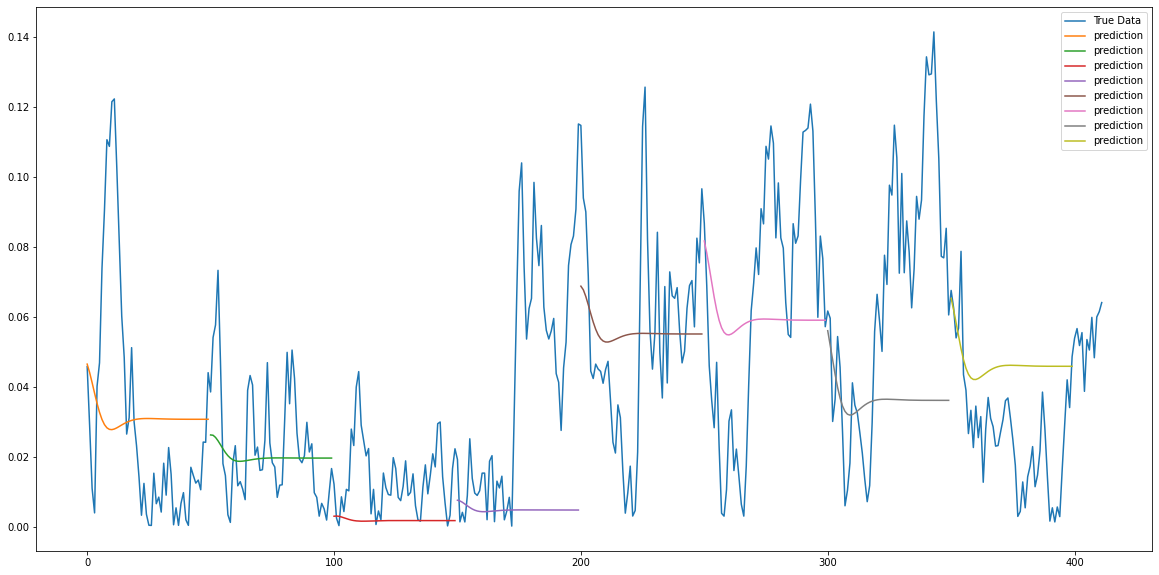

In [ ]:
plot_result_multiple(predictions, y_test, 50)

[참고 링크1](https://github.com/KerasKorea/KEKOxTutorial/blob/master/22_Keras%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EC%8B%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1.md)


[참고 링크2](https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo)